# 01 - Data Exploration & Entropy Analysis

This notebook explores collected GitHub data and calculates entropy metrics for Stadium project classification.

**Prerequisites:**
- Run `00_setup_and_test.ipynb` first to collect data
- Data files should exist in `data/raw/`

**Goals:**
1. Load and explore collected project data
2. Calculate contributor entropy (Shannon entropy)
3. Analyze dominance patterns
4. Validate Stadium classification criteria

## Setup

In [10]:
import json
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add src to path
sys.path.insert(0, '../src')

from analysis.entropy_calculation import EntropyCalculator

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

print("✅ Setup complete!")

✅ Setup complete!


## 1. Load Collected Data

In [11]:
# Find all collected data files
data_dir = Path("../data/raw")
data_files = list(data_dir.glob("*_data.json"))

print(f"Found {len(data_files)} data file(s):")
for f in data_files:
    size_kb = f.stat().st_size / 1024
    print(f"  - {f.name} ({size_kb:.1f} KB)")

Found 38 data file(s):
  - babel_babel_data.json (338.7 KB)
  - benjaminp_six_data.json (35.1 KB)
  - glennrp_libpng_data.json (187.4 KB)
  - curl_curl_data.json (2017.5 KB)
  - psf_requests_data.json (195.1 KB)
  - rust-random_rand_data.json (140.0 KB)
  - yaml_pyyaml_data.json (38.5 KB)
  - pypa_pip_data.json (478.8 KB)
  - sindresorhus_got_data.json (93.1 KB)
  - debug-js_debug_data.json (41.9 KB)
  - uuidjs_uuid_data.json (57.7 KB)
  - vercel_ms_data.json (49.1 KB)
  - sqlite_sqlite_data.json (8.1 KB)
  - rack_rack_data.json (117.7 KB)
  - tj_commander.js_data.json (163.8 KB)
  - lodash_lodash_data.json (80.8 KB)
  - dateutil_dateutil_data.json (42.6 KB)
  - yargs_yargs_data.json (67.5 KB)
  - clap-rs_clap_data.json (383.3 KB)
  - sparklemotion_nokogiri_data.json (309.2 KB)
  - expressjs_express_data.json (185.1 KB)
  - pallets_click_data.json (303.4 KB)
  - gorilla_mux_data.json (22.6 KB)
  - ibrahimcesar_react-lite-youtube-embed_data.json (230.8 KB)
  - zloirock_core-js_data.json

In [12]:
# Load all project data
projects = {}

for file_path in data_files:
    with open(file_path, 'r') as f:
        data = json.load(f)
        repo_name = data['repository']['full_name']
        projects[repo_name] = data
        print(f"Loaded: {repo_name}")

print(f"\n✅ Loaded {len(projects)} project(s)")

Loaded: babel/babel
Loaded: benjaminp/six
Loaded: pnggroup/libpng
Loaded: curl/curl
Loaded: psf/requests
Loaded: rust-random/rand
Loaded: yaml/pyyaml
Loaded: pypa/pip
Loaded: sindresorhus/got
Loaded: debug-js/debug
Loaded: uuidjs/uuid
Loaded: vercel/ms
Loaded: sqlite/sqlite
Loaded: rack/rack
Loaded: tj/commander.js
Loaded: lodash/lodash
Loaded: dateutil/dateutil
Loaded: yargs/yargs
Loaded: clap-rs/clap
Loaded: sparklemotion/nokogiri
Loaded: expressjs/express
Loaded: pallets/click
Loaded: gorilla/mux
Loaded: ibrahimcesar/react-lite-youtube-embed
Loaded: zloirock/core-js
Loaded: chalk/chalk
Loaded: rust-lang/regex
Loaded: serde-rs/json
Loaded: spf13/cobra
Loaded: certifi/python-certifi
Loaded: node-fetch/node-fetch
Loaded: python-attrs/attrs
Loaded: serde-rs/serde
Loaded: axios/axios
Loaded: npm/node-semver
Loaded: tokio-rs/tokio
Loaded: urllib3/urllib3
Loaded: madler/zlib

✅ Loaded 38 project(s)


## 2. Explore Project Metrics

In [13]:
# Create summary DataFrame
summary_data = []

for repo_name, data in projects.items():
    repo = data['repository']
    maintainers = data['maintainers']['statistics']
    pr_stats = data['pull_requests']['statistics']
    issue_stats = data['issues']['statistics']
    
    summary_data.append({
        'repository': repo_name,
        'stars': repo.get('stargazers_count', 0),
        'forks': repo.get('forks_count', 0),
        'language': repo.get('language', 'Unknown'),
        'contributors': len(data['contributors']),
        'active_maintainers': maintainers.get('active_maintainers_6mo', 0),
        'commits': len(data['recent_commits']),
        'total_prs': pr_stats.get('total_prs', 0),
        'merge_rate': pr_stats.get('merged_count', 0) / max(pr_stats.get('total_prs', 1), 1),
        'avg_merge_time_hrs': pr_stats.get('avg_time_to_merge', 0),
        'conflict_rate': pr_stats.get('conflict_rate', 0),
        'total_issues': issue_stats.get('total_issues', 0),
        'avg_close_time_hrs': issue_stats.get('avg_time_to_close', 0),
    })

df_summary = pd.DataFrame(summary_data)
df_summary

,repository,stars,forks,language,contributors,active_maintainers,commits,total_prs,merge_rate,avg_merge_time_hrs,conflict_rate,total_issues,avg_close_time_hrs
0,babel/babel,43813,5777,TypeScript,100,4,462,200,0.920000,312.398682,0.035000,38,229.656184
1,benjaminp/six,1018,273,Python,58,1,17,14,0.785714,25.158914,0.142857,5,9177.583556
2,pnggroup/libpng,1510,733,C,85,4,176,75,0.506667,115.509423,0.146667,46,2049.391014
3,curl/curl,39986,6953,C,100,12,3268,200,0.000000,0.000000,0.025000,14,40.136071
4,psf/requests,53508,9612,Python,100,2,57,200,0.410000,802.512815,0.110000,88,172.075104
5,rust-random/rand,1941,481,Rust,100,2,149,98,0.744898,209.031842,0.061224,57,4767.683026
6,yaml/pyyaml,2810,556,Python,37,0,1,13,0.230769,6637.849074,0.307692,20,6647.146222
7,pypa/pip,10010,3182,Python,100,12,754,200,0.650000,1177.169038,0.100000,77,470.719235
8,sindresorhus/got,14798,970,TypeScript,100,1,89,8,0.625000,187.814722,0.000000,148,21518.437297
9,debug-js/debug,11399,961,JavaScript,100,0,7,12,0.250000,10483.022130,0.000000,27,3722.480741


## 3. Calculate Contributor Entropy

**Shannon Entropy** measures the distribution of contributions:
- **Low entropy** → Concentrated contributions (few dominant contributors) → Stadium characteristic
- **High entropy** → Distributed contributions (many equal contributors) → Federation characteristic

In [14]:
# Initialize entropy calculator
entropy_calc = EntropyCalculator()

# Calculate entropy for each project
entropy_results = []

for repo_name, data in projects.items():
    contributors = data['contributors']
    
    if len(contributors) > 0:
        # Calculate contributor entropy
        entropy, normalized_entropy = entropy_calc.contributor_entropy(contributors)
        
        # Calculate dominance metrics
        total_contributions = sum(c['contributions'] for c in contributors)
        top_contributor = contributors[0]
        top_2_contributions = sum(c['contributions'] for c in contributors[:2])
        
        entropy_results.append({
            'repository': repo_name,
            'entropy': entropy,
            'normalized_entropy': normalized_entropy,
            'max_possible_entropy': np.log2(len(contributors)),
            'top_contributor': top_contributor['login'],
            'top_contributor_pct': top_contributor['contributions'] / total_contributions * 100,
            'top_2_pct': top_2_contributions / total_contributions * 100,
            'gini_coefficient': entropy_calc.gini_coefficient([c['contributions'] for c in contributors])
        })
        
        print(f"\n{repo_name}:")
        print(f"  Shannon Entropy: {entropy:.3f} bits")
        print(f"  Normalized Entropy: {normalized_entropy:.3f} (0=concentrated, 1=uniform)")
        print(f"  Top Contributor: {top_contributor['login']} ({top_contributor['contributions'] / total_contributions * 100:.1f}%)")

df_entropy = pd.DataFrame(entropy_results)
df_entropy


babel/babel:
  Shannon Entropy: 3.877 bits
  Normalized Entropy: 0.584 (0=concentrated, 1=uniform)
  Top Contributor: sebmck (36.0%)

benjaminp/six:
  Shannon Entropy: 2.117 bits
  Normalized Entropy: 0.361 (0=concentrated, 1=uniform)
  Top Contributor: benjaminp (73.3%)

pnggroup/libpng:
  Shannon Entropy: 2.304 bits
  Normalized Entropy: 0.360 (0=concentrated, 1=uniform)
  Top Contributor: jbowler (46.2%)

curl/curl:
  Shannon Entropy: 2.800 bits
  Normalized Entropy: 0.421 (0=concentrated, 1=uniform)
  Top Contributor: bagder (57.3%)

psf/requests:
  Shannon Entropy: 3.895 bits
  Normalized Entropy: 0.586 (0=concentrated, 1=uniform)
  Top Contributor: kennethreitz (31.6%)

rust-random/rand:
  Shannon Entropy: 3.747 bits
  Normalized Entropy: 0.564 (0=concentrated, 1=uniform)
  Top Contributor: dhardy (37.7%)

yaml/pyyaml:
  Shannon Entropy: 2.780 bits
  Normalized Entropy: 0.534 (0=concentrated, 1=uniform)
  Top Contributor: xitology (54.2%)

pypa/pip:
  Shannon Entropy: 4.583 bits

,repository,entropy,normalized_entropy,max_possible_entropy,top_contributor,top_contributor_pct,top_2_pct,gini_coefficient
0,babel/babel,3.876777,0.583513,6.643856,sebmck,36.007840,44.852086,0.851371
1,benjaminp/six,2.116901,0.361370,5.857981,benjaminp,73.320896,77.985075,0.856215
2,pnggroup/libpng,2.304332,0.359524,6.409391,jbowler,46.168582,85.249042,0.887582
3,curl/curl,2.800249,0.421479,6.643856,bagder,57.277036,64.753482,0.913666
4,psf/requests,3.895246,0.586293,6.643856,kennethreitz,31.625275,50.801635,0.790195
5,rust-random/rand,3.747126,0.563999,6.643856,dhardy,37.667304,52.676864,0.827374
6,yaml/pyyaml,2.779728,0.533593,5.209453,xitology,54.179567,62.848297,0.798427
7,pypa/pip,4.582960,0.689804,6.643856,pradyunsg,22.127782,33.062018,0.784387
8,sindresorhus/got,2.857398,0.430081,6.643856,sindresorhus,35.477454,66.578249,0.889284
9,debug-js/debug,3.817863,0.574646,6.643856,TooTallNate,35.533981,53.009709,0.771398


## 4. Visualize Contribution Distribution

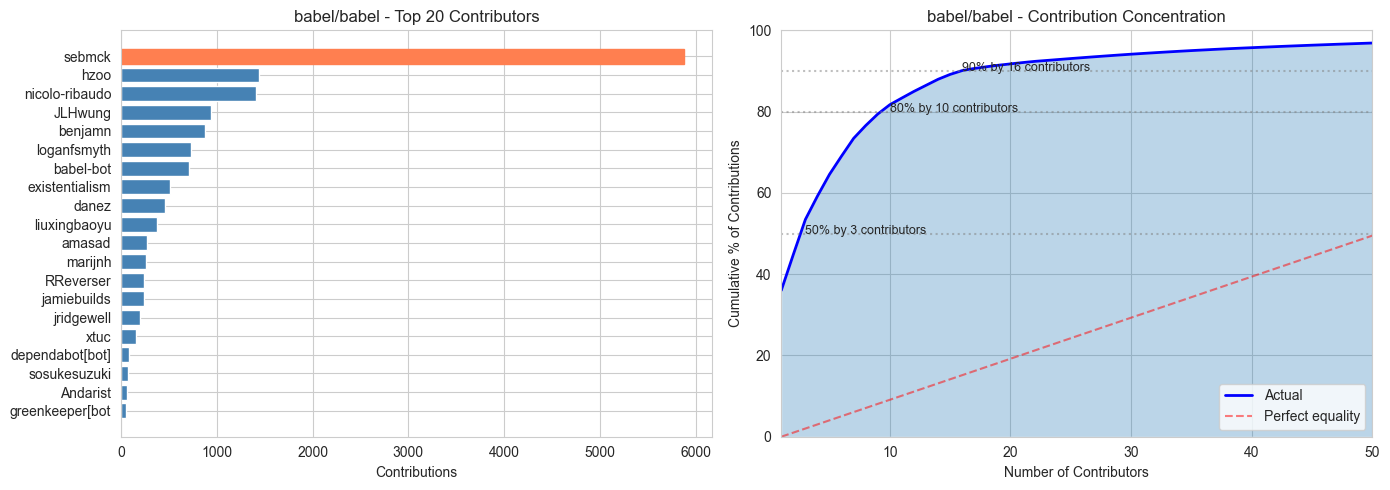

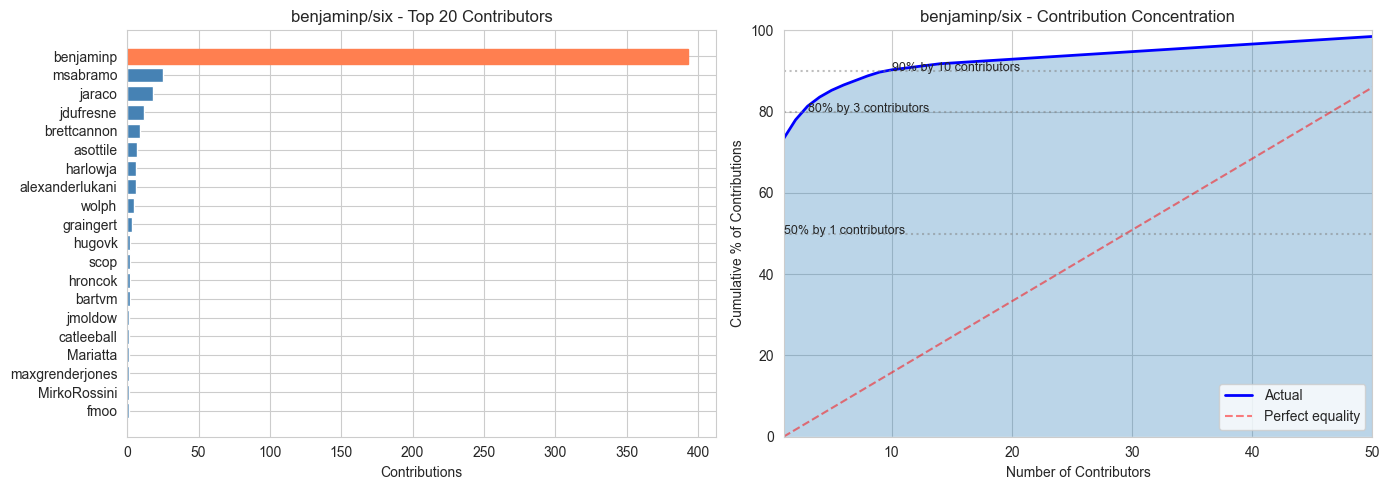

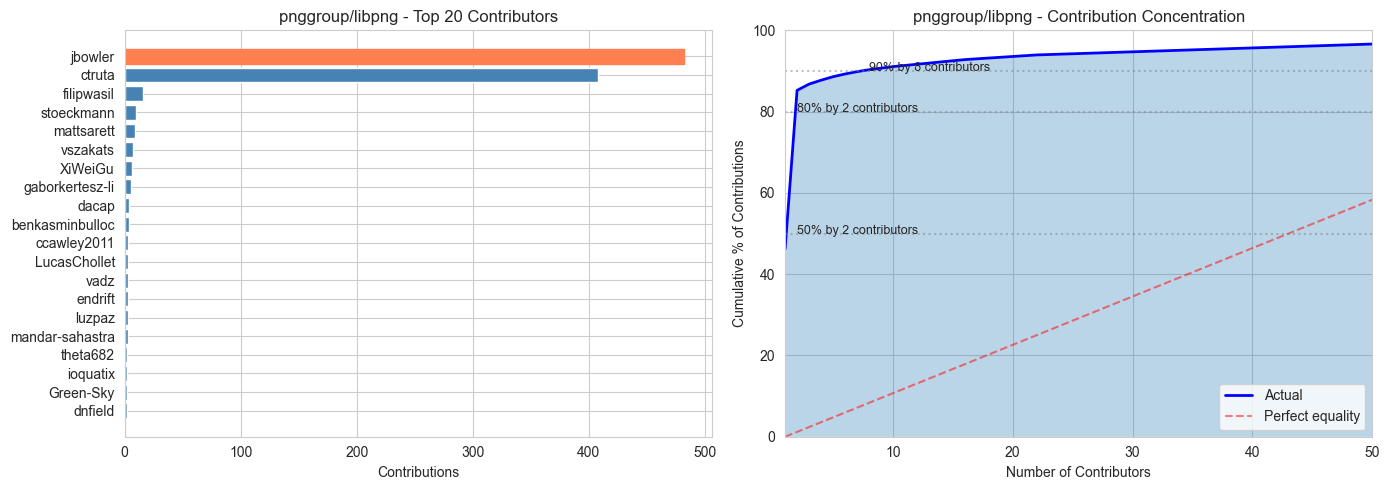

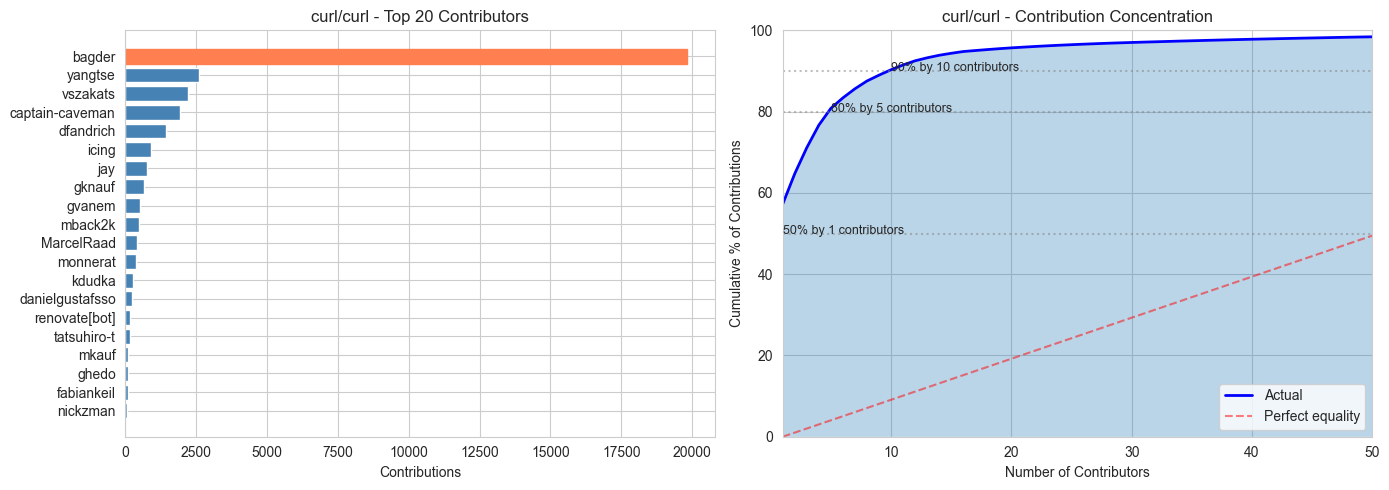

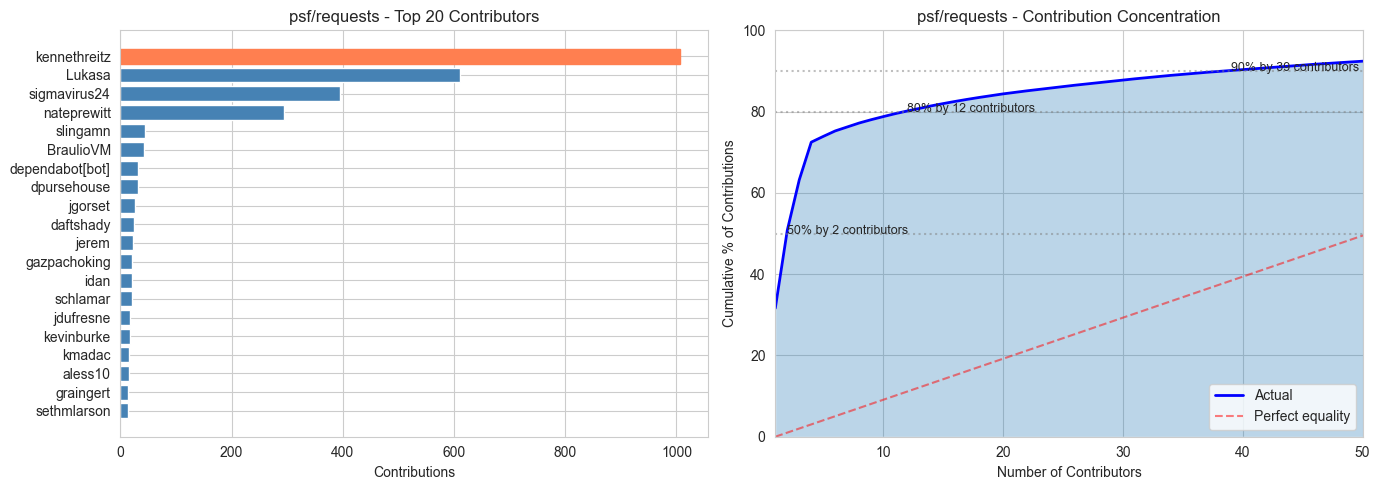

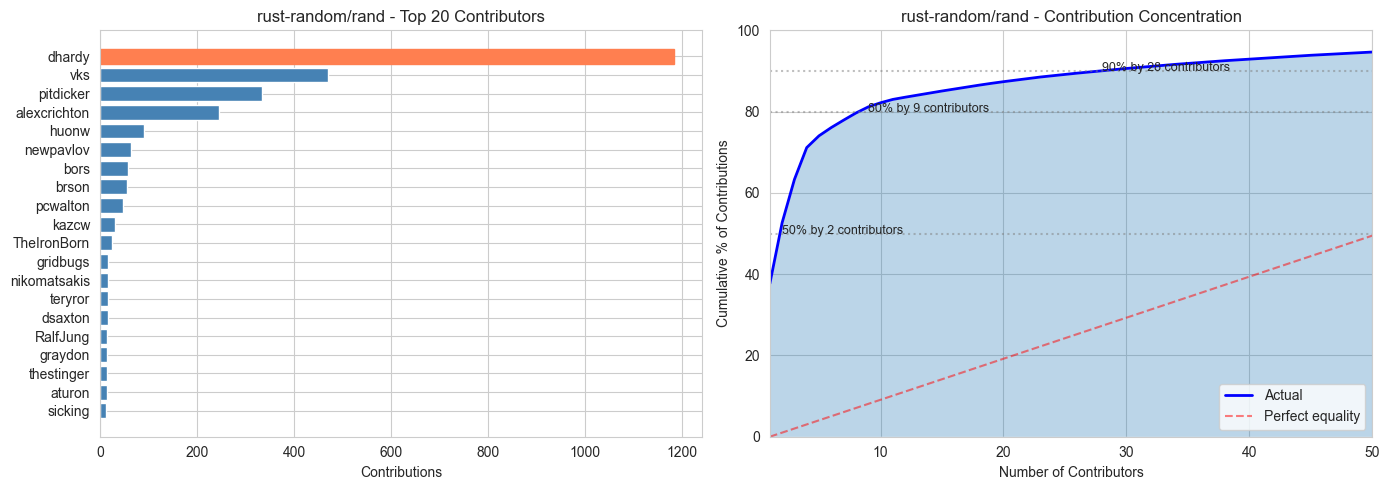

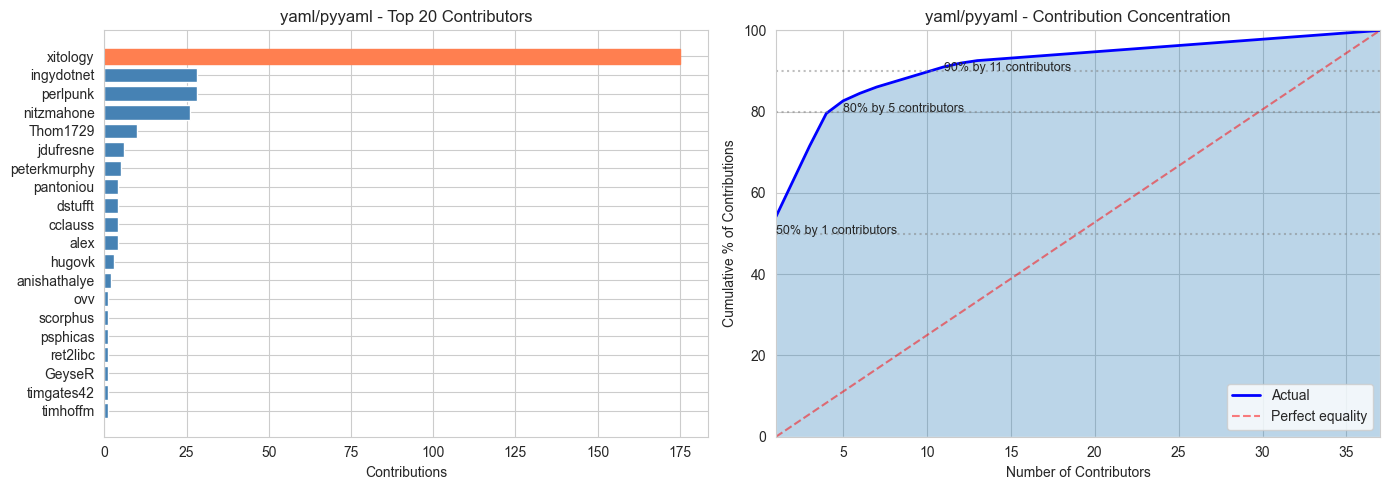

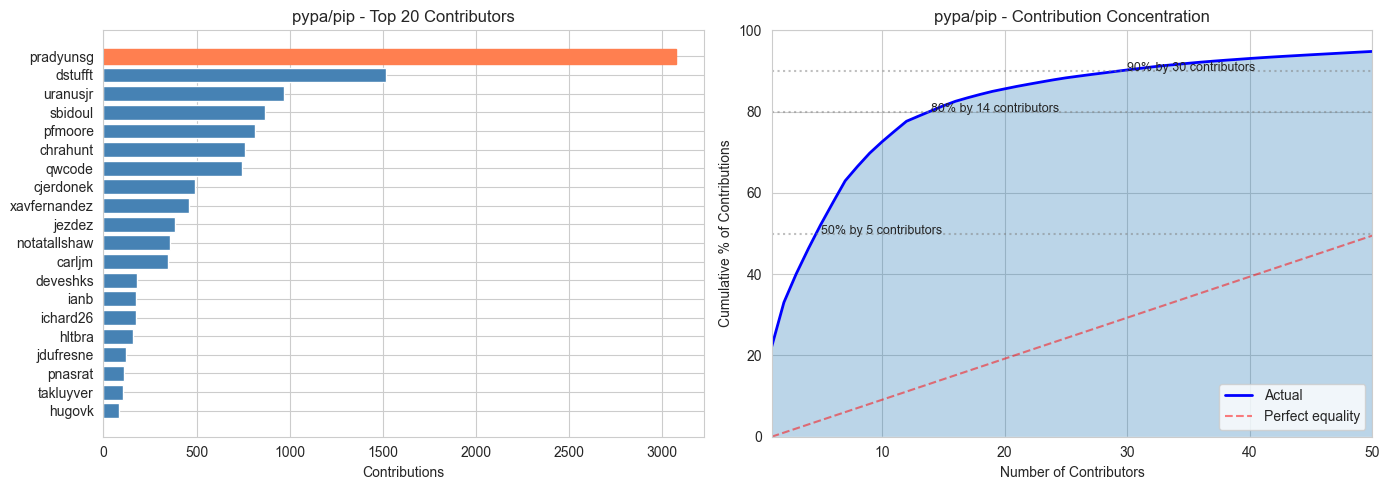

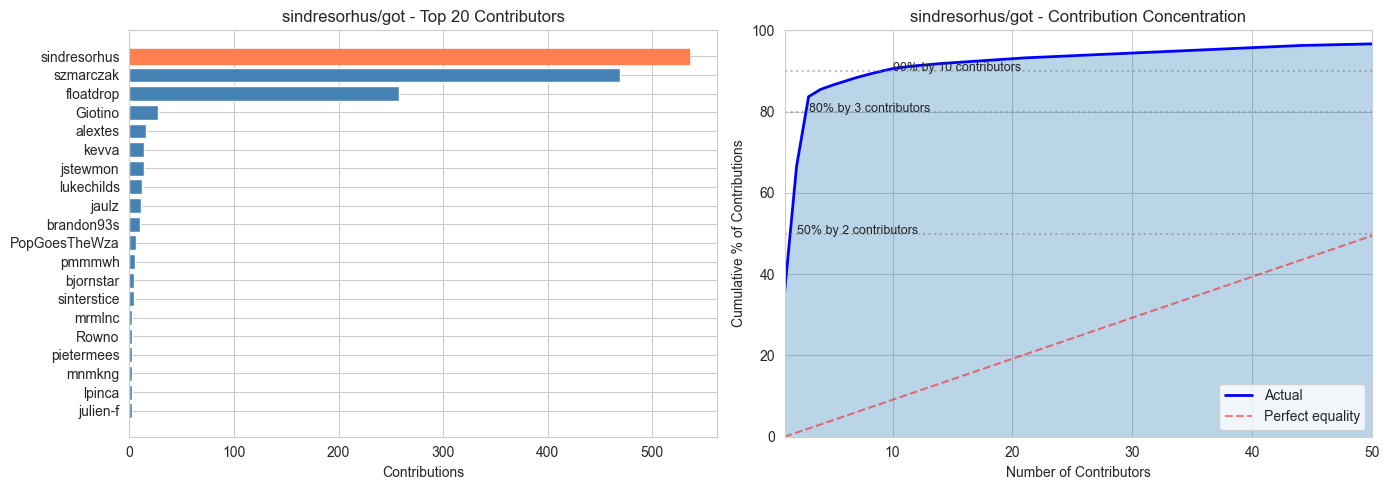

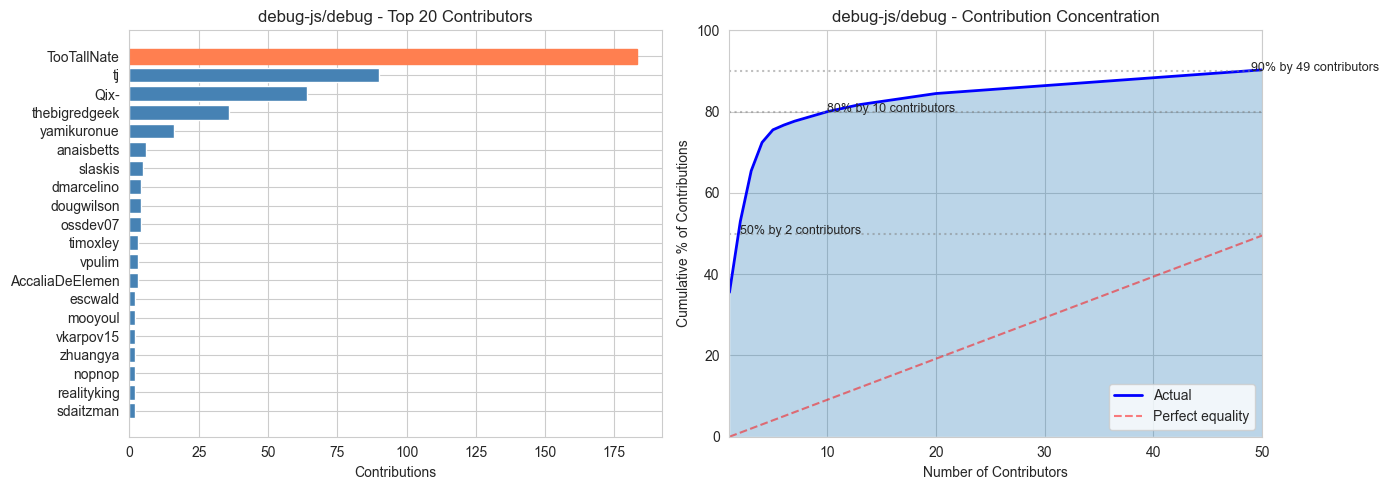

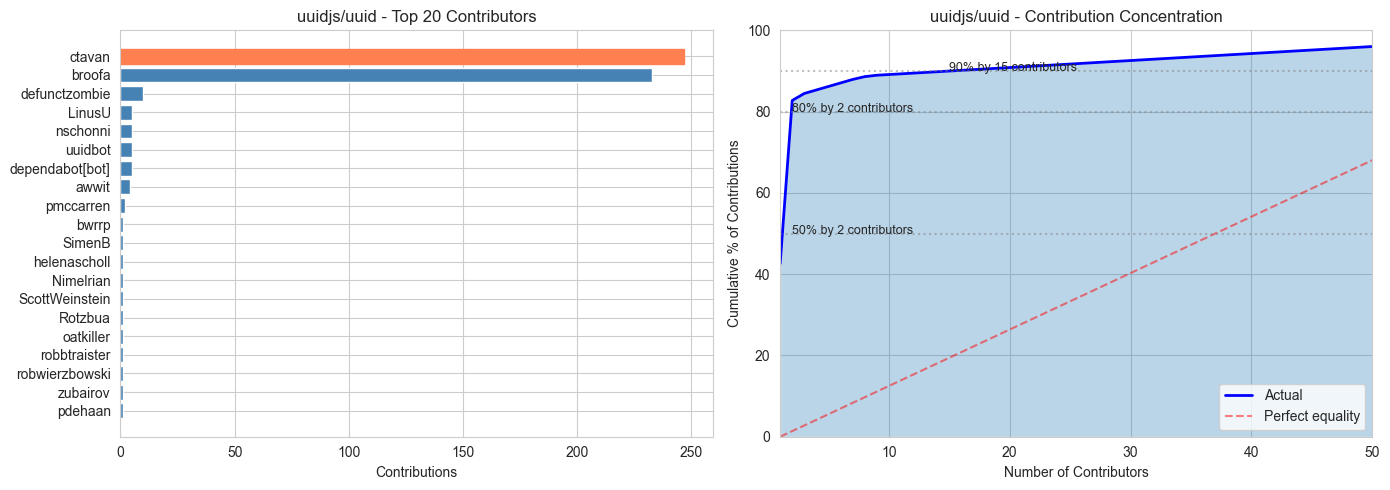

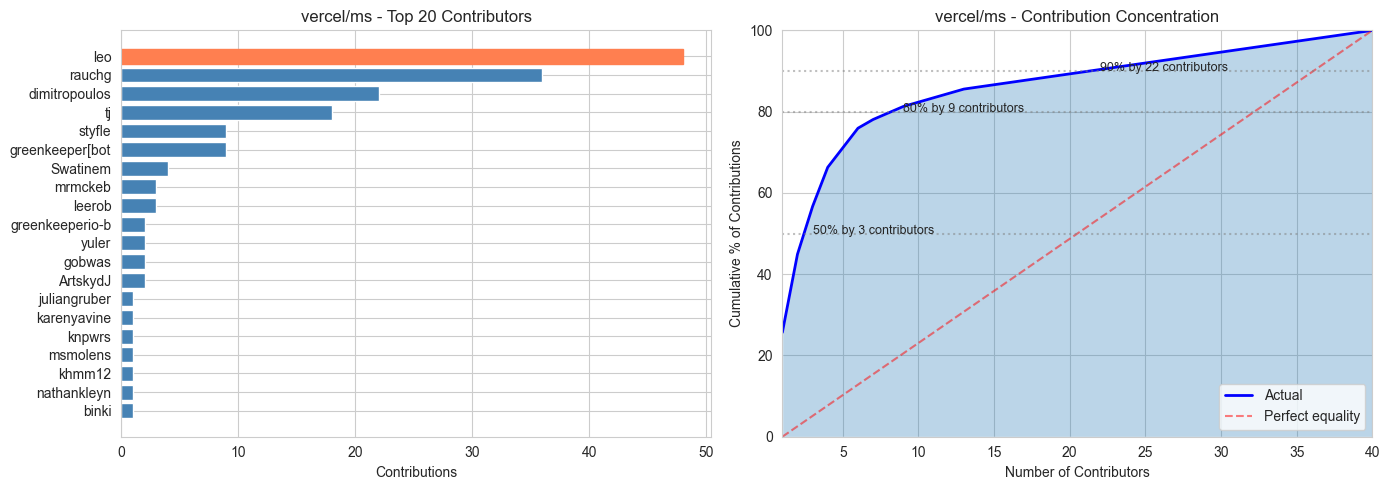

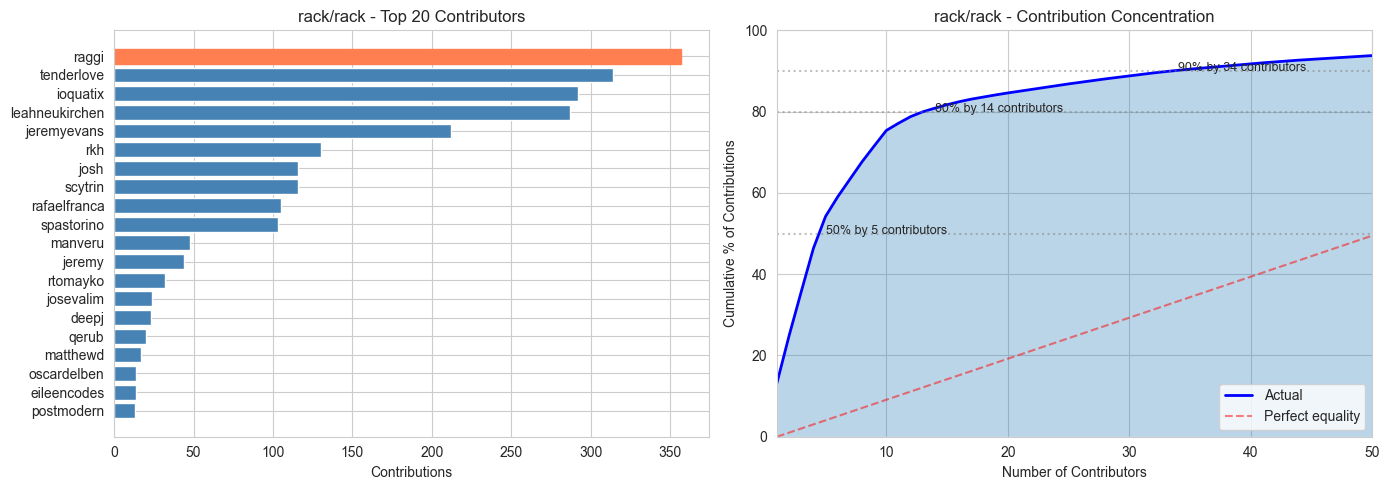

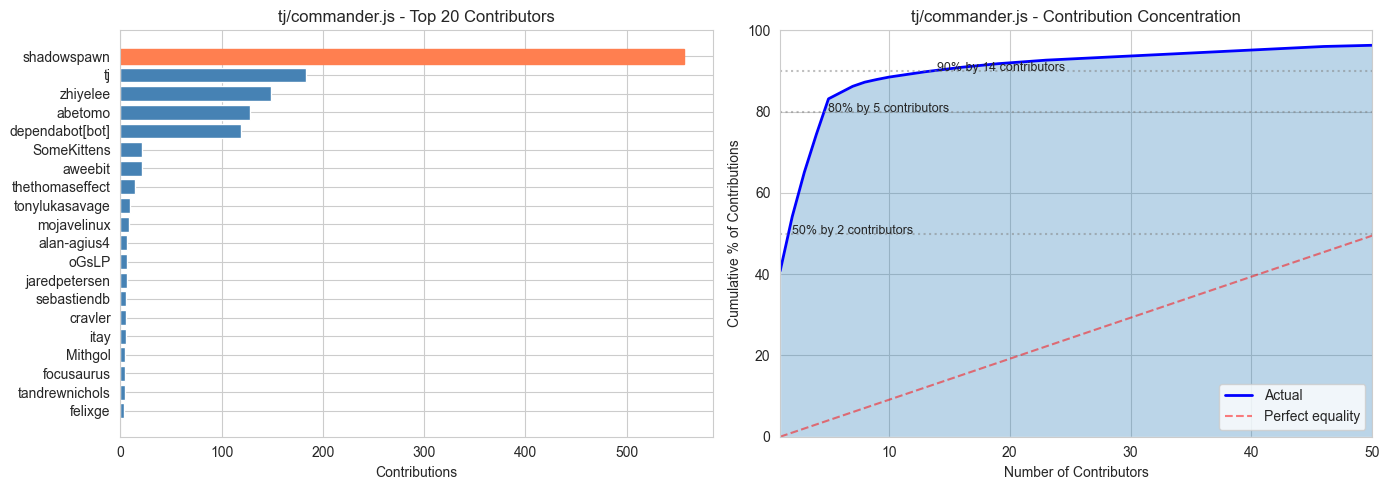

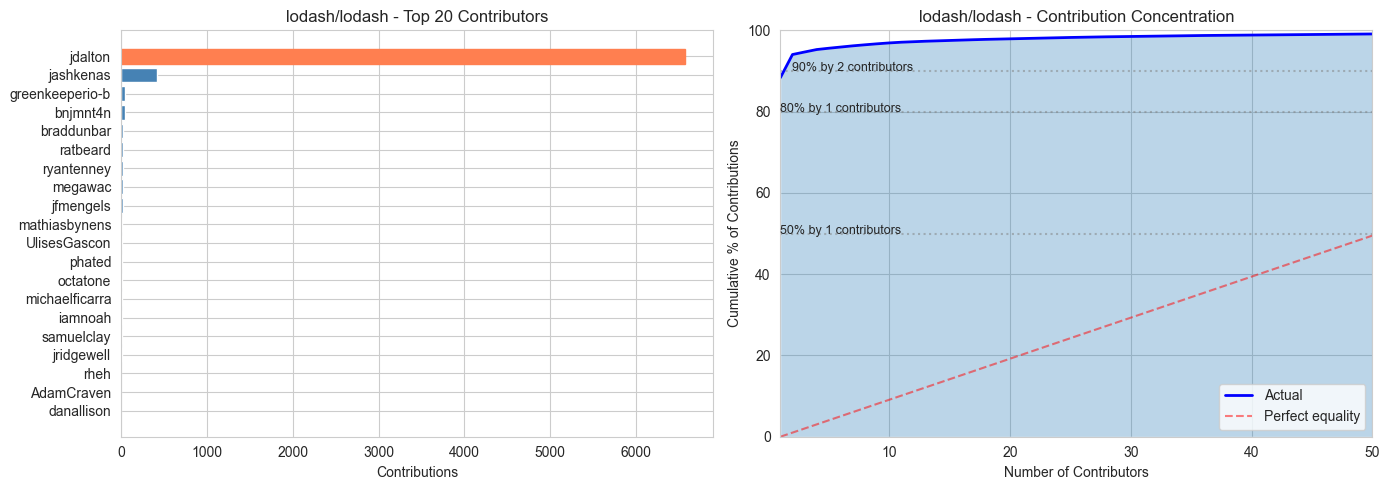

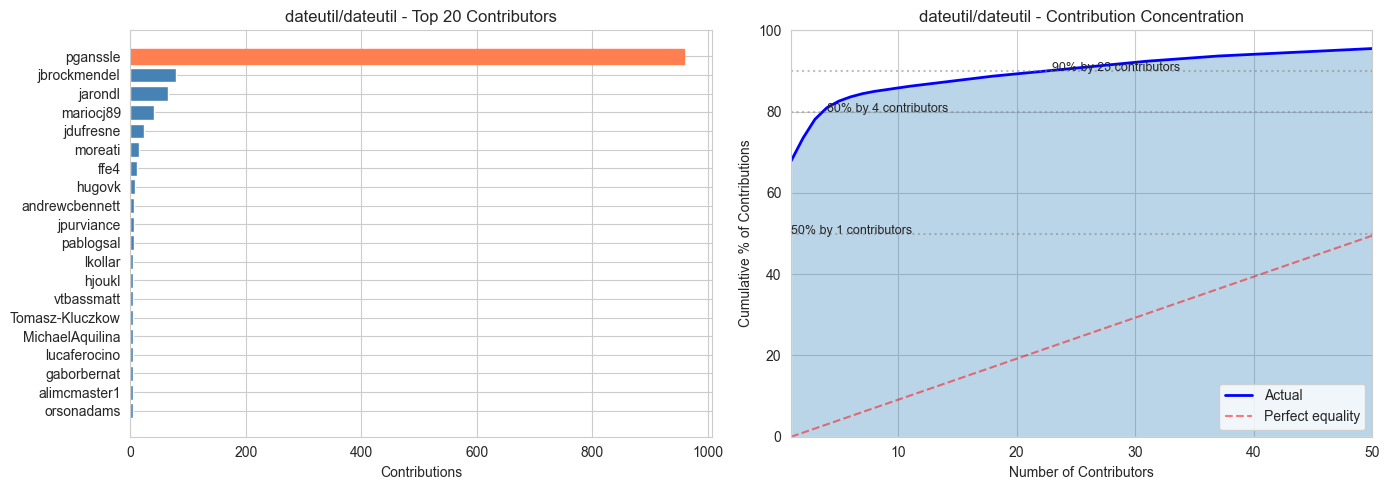

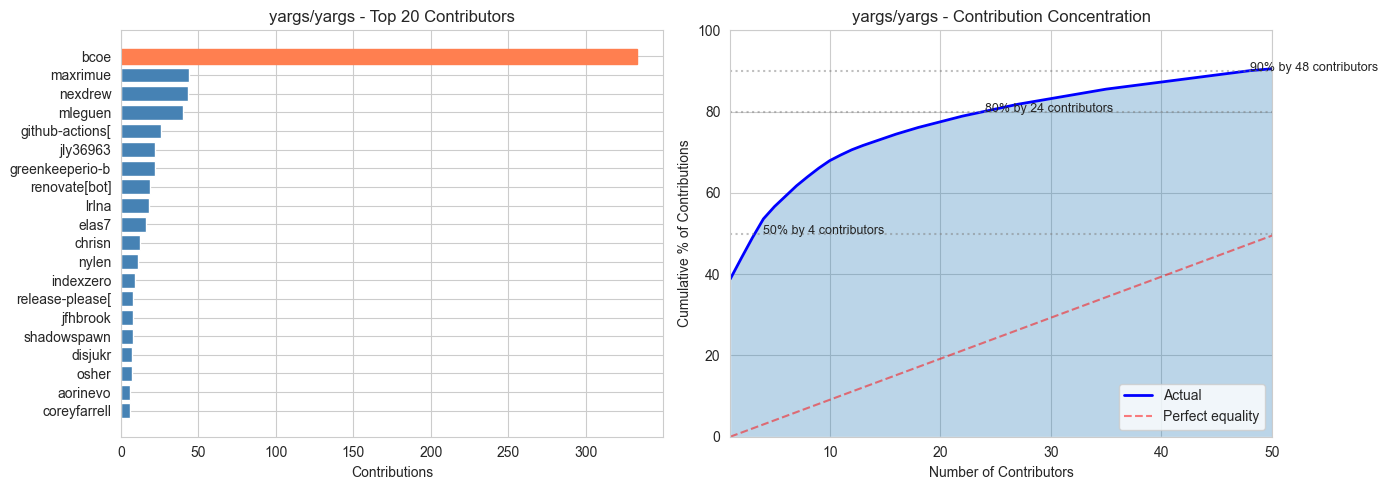

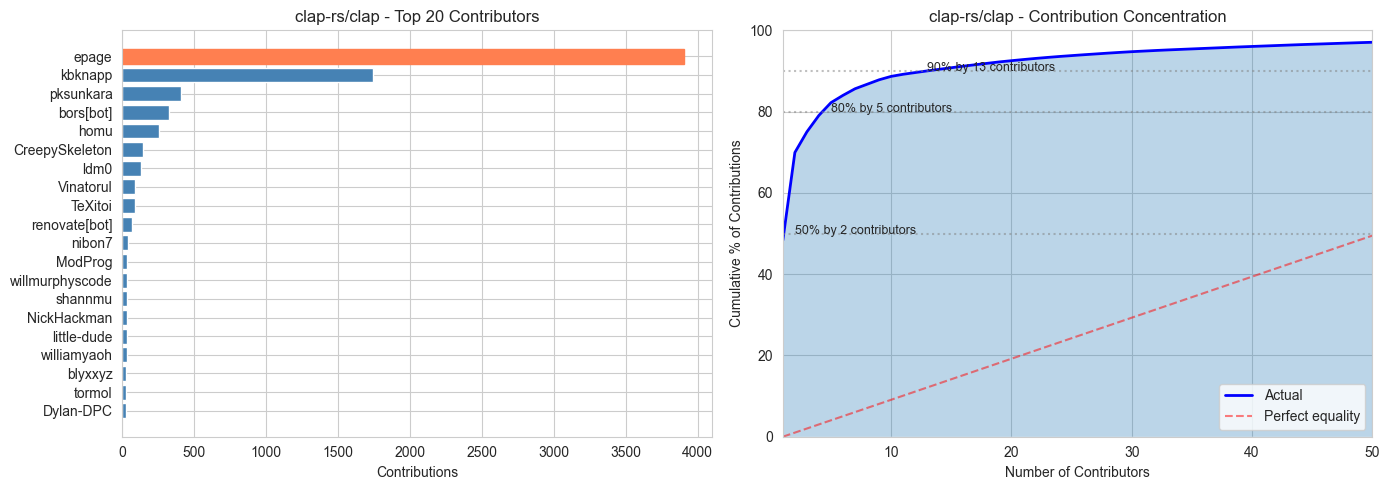

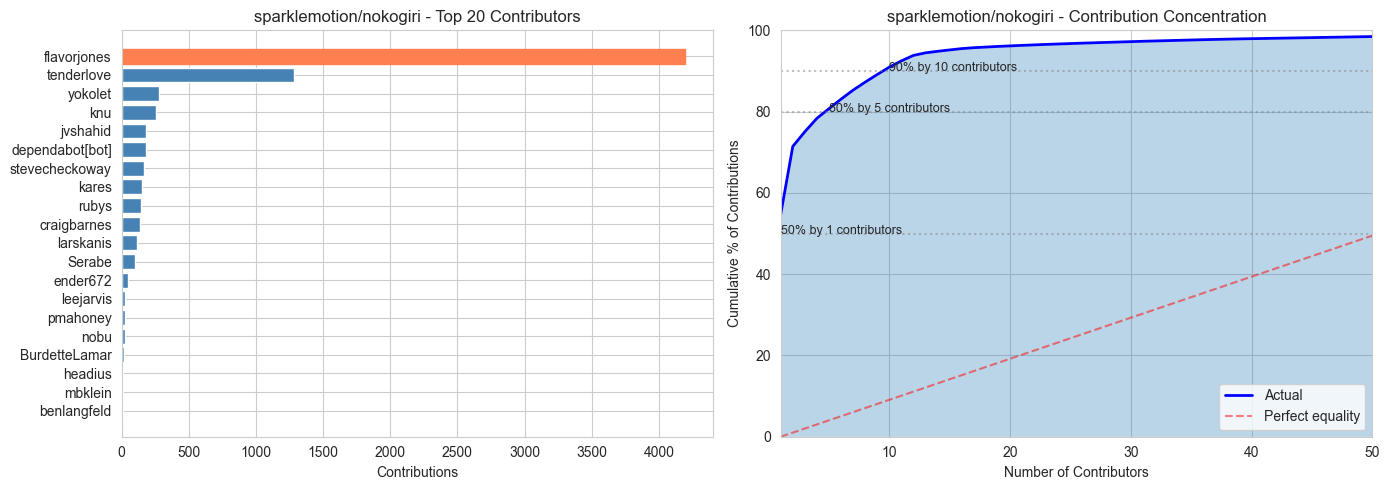

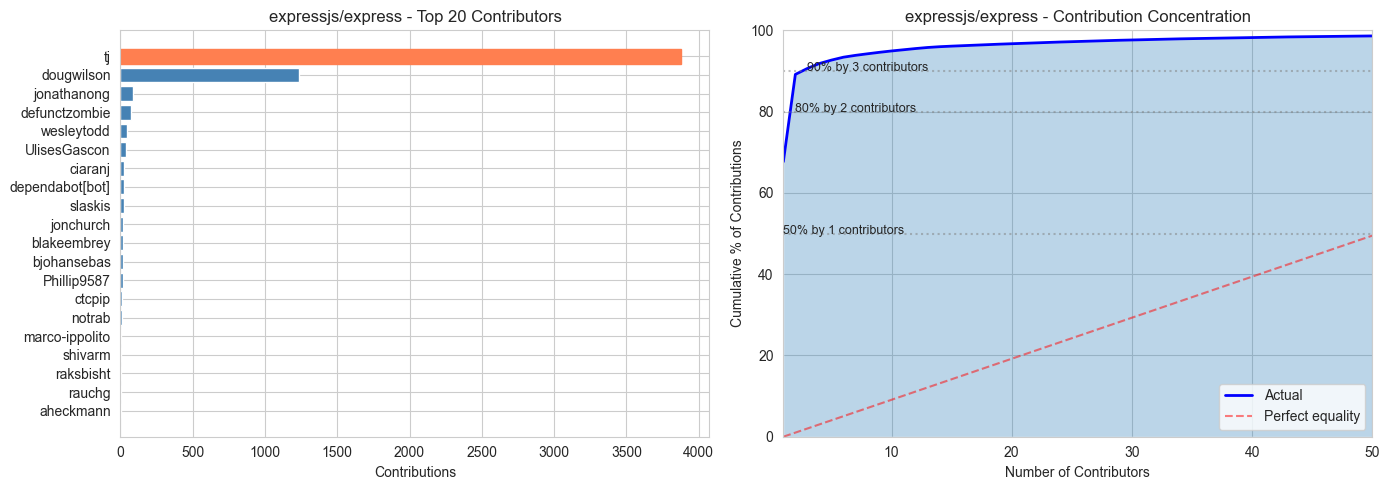

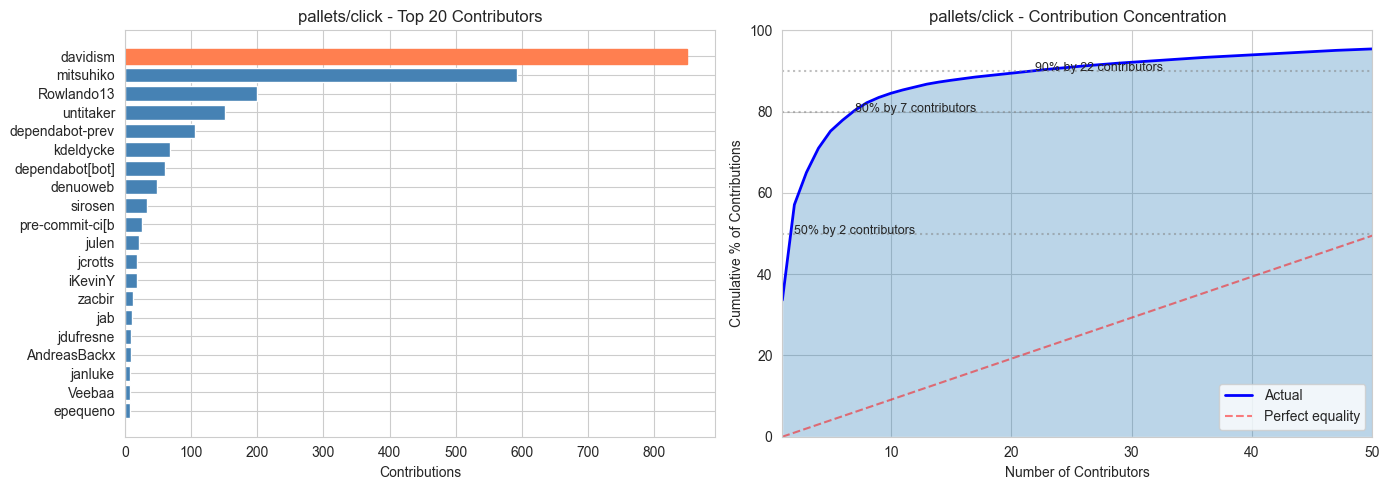

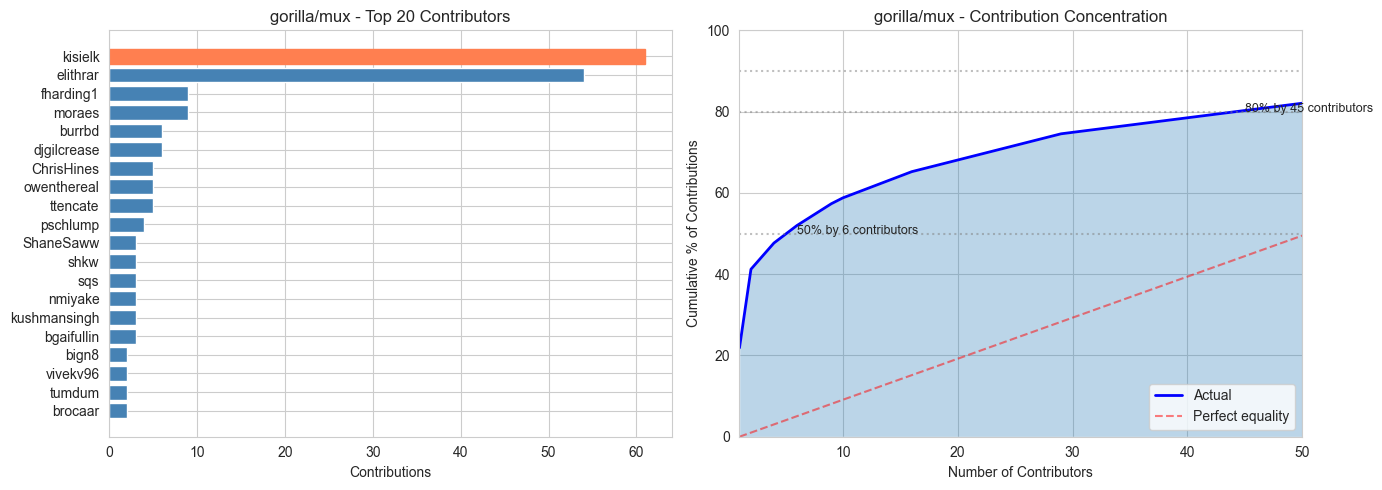

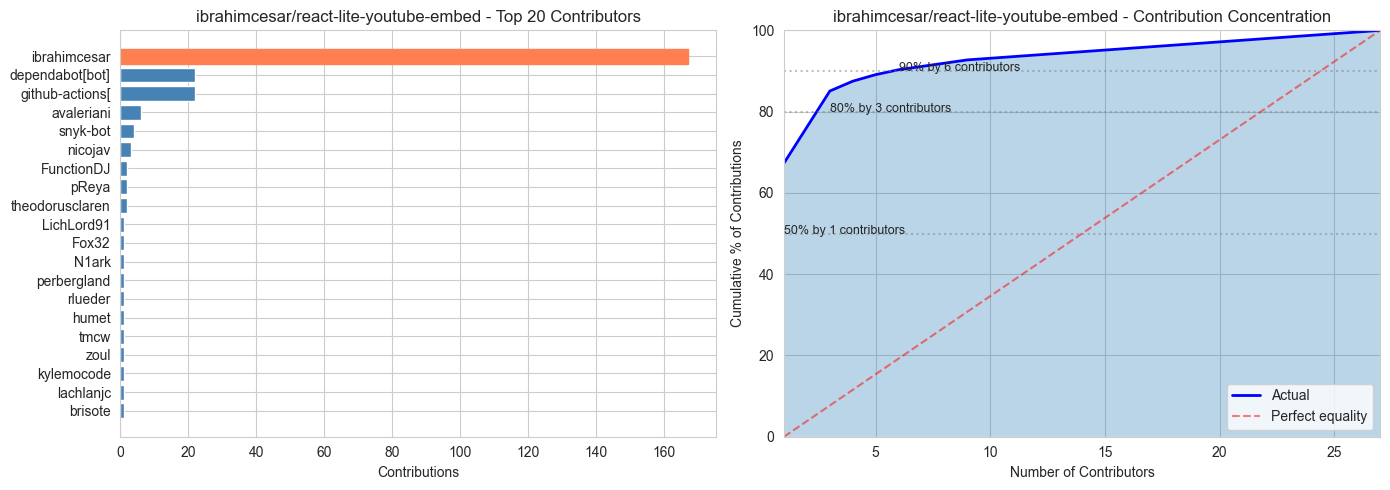

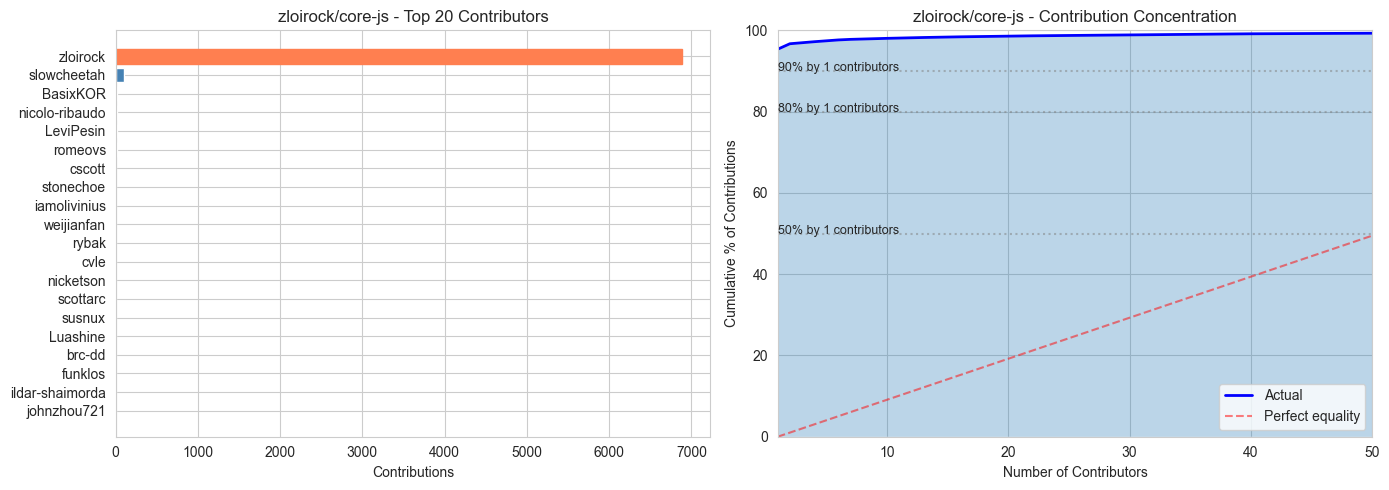

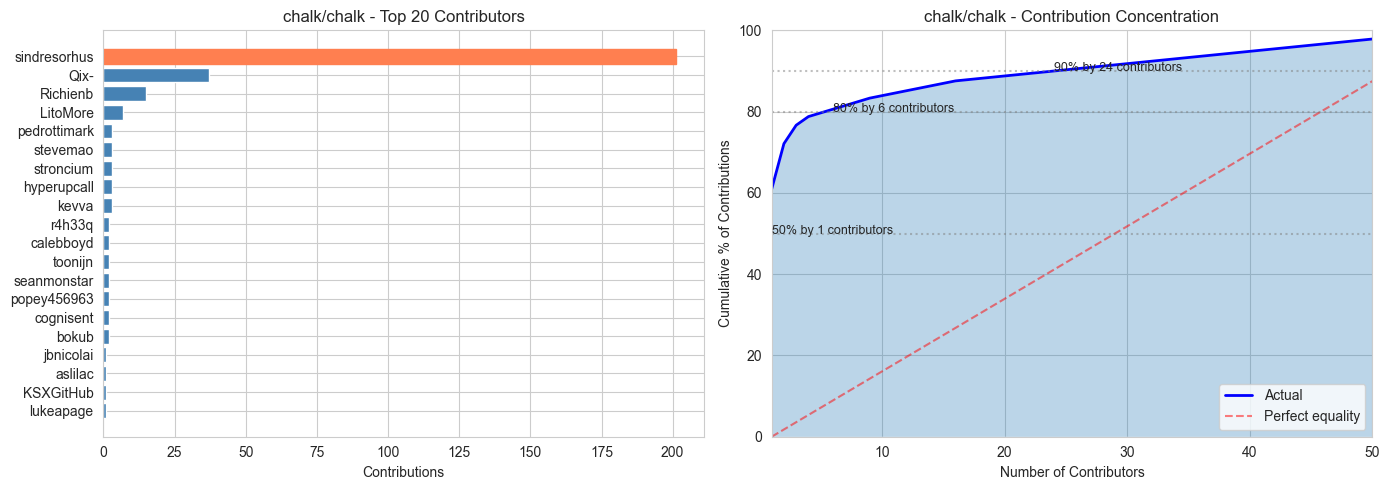

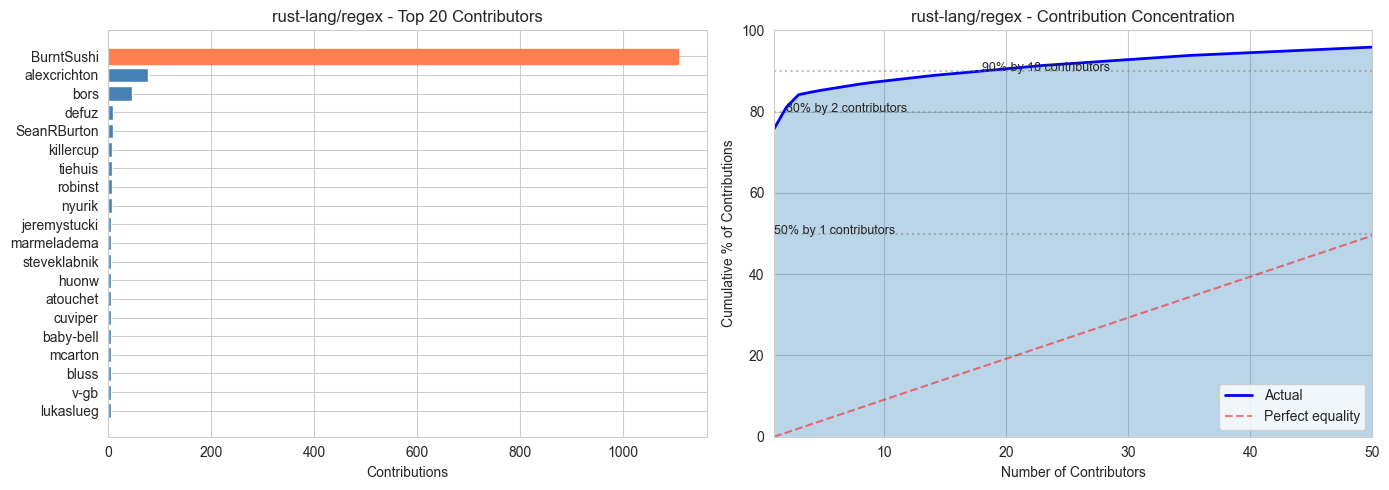

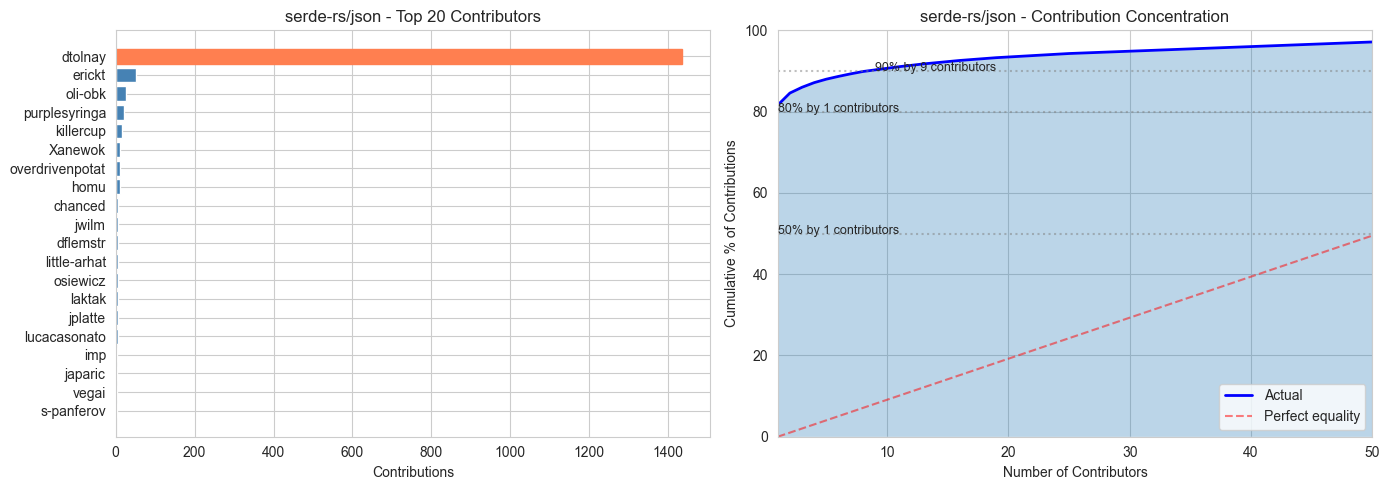

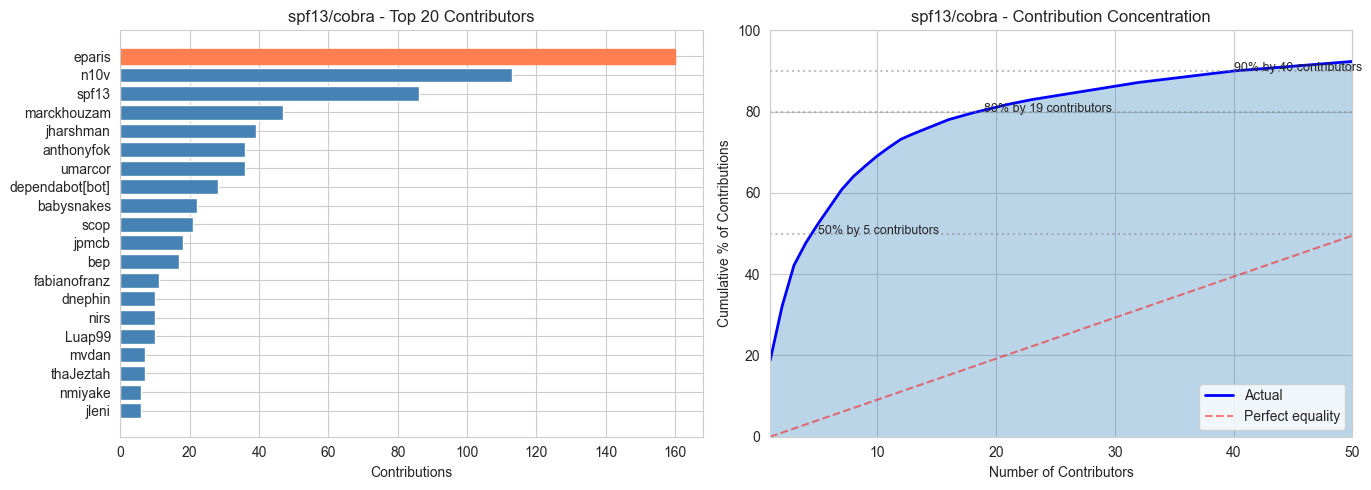

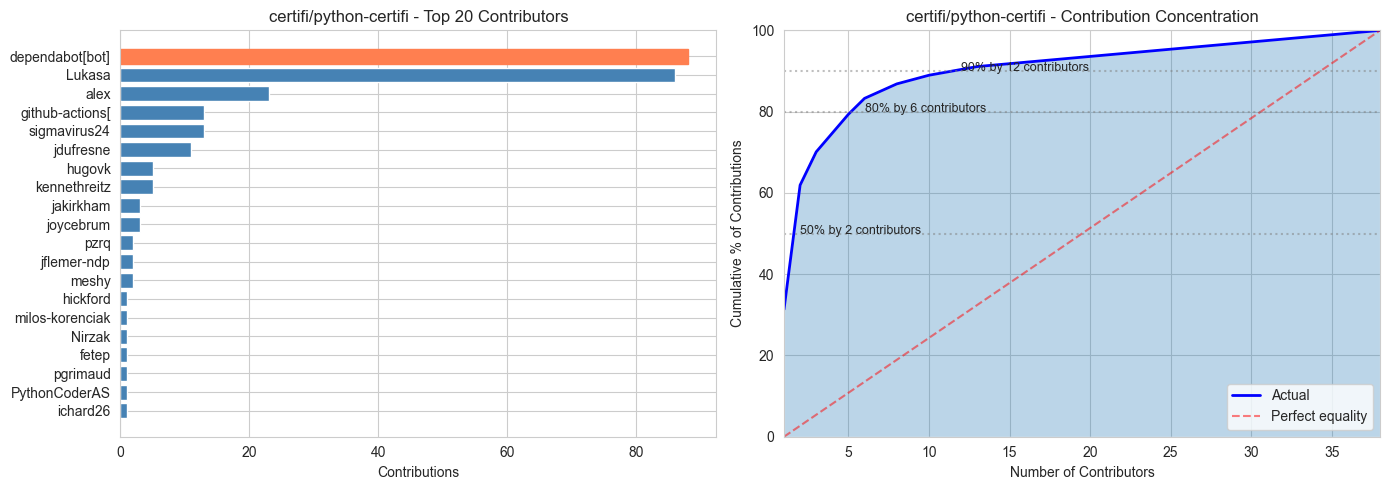

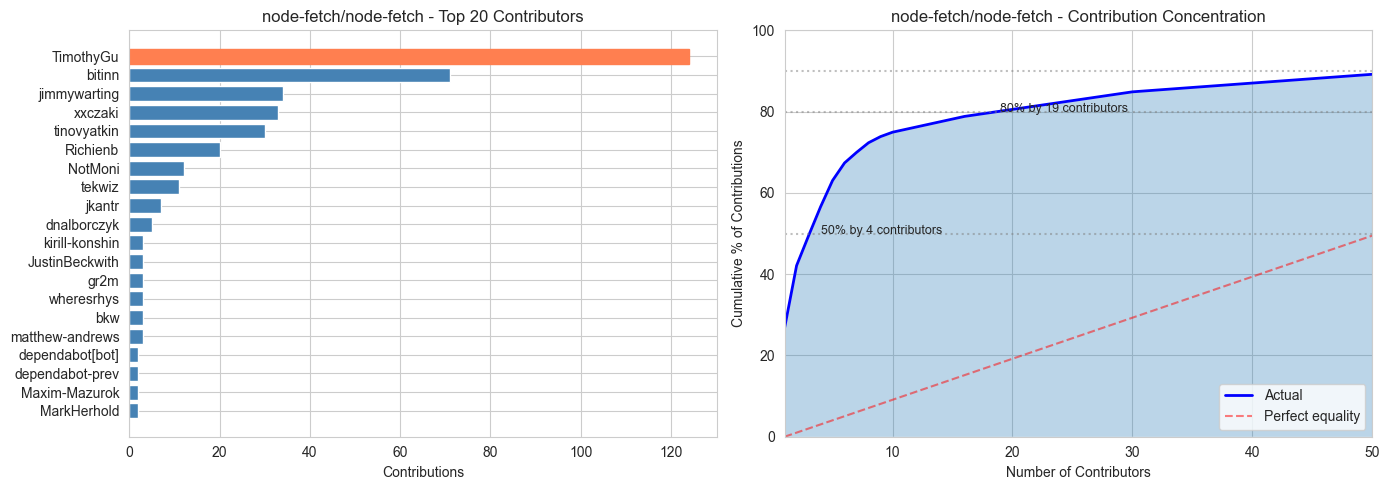

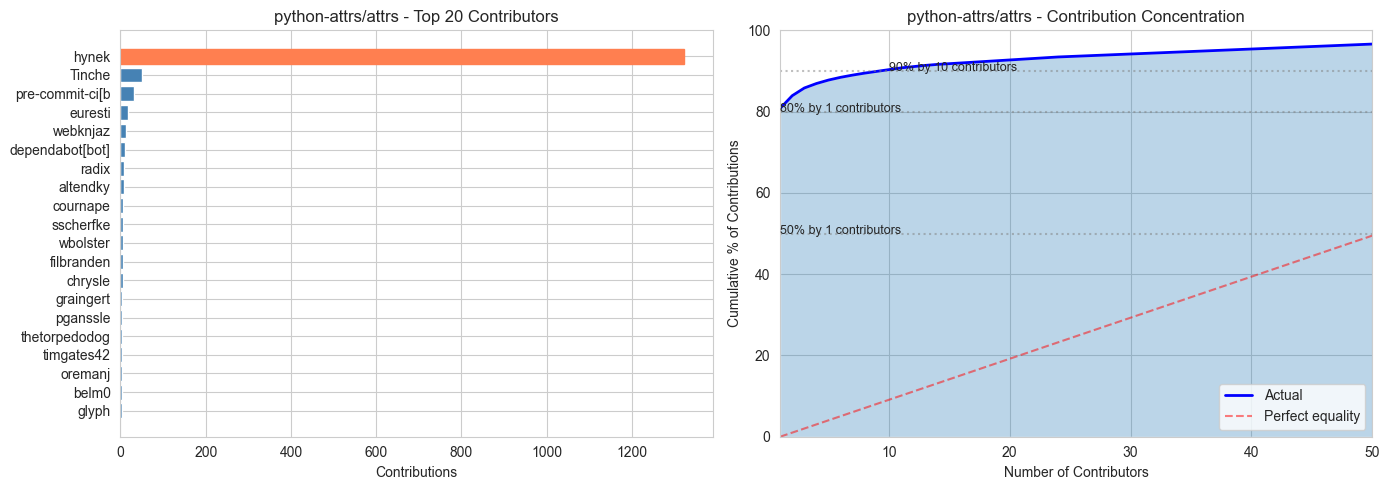

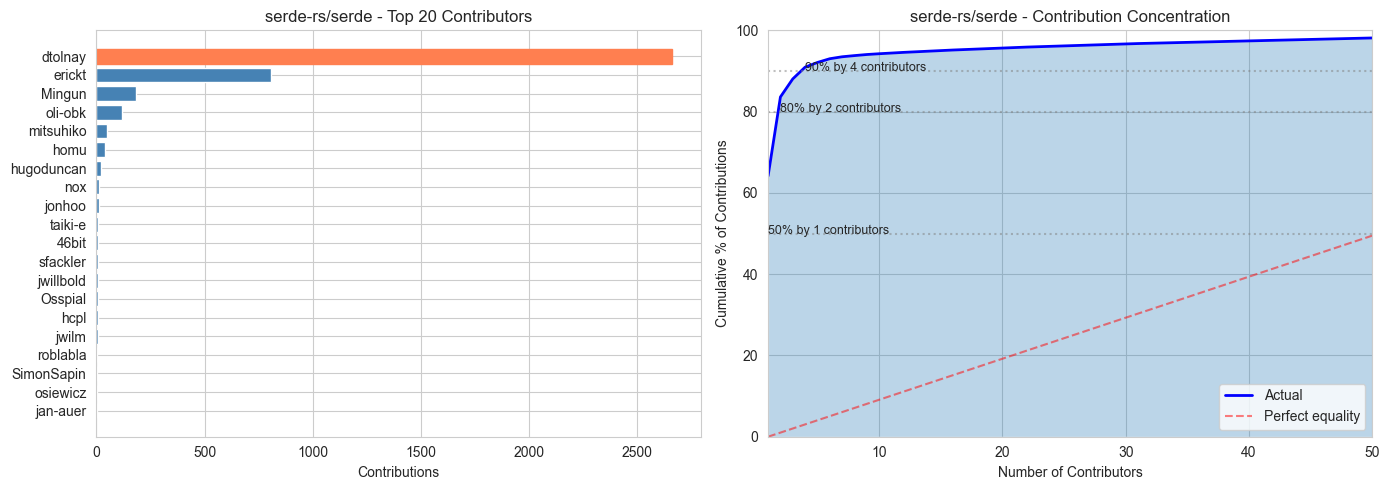

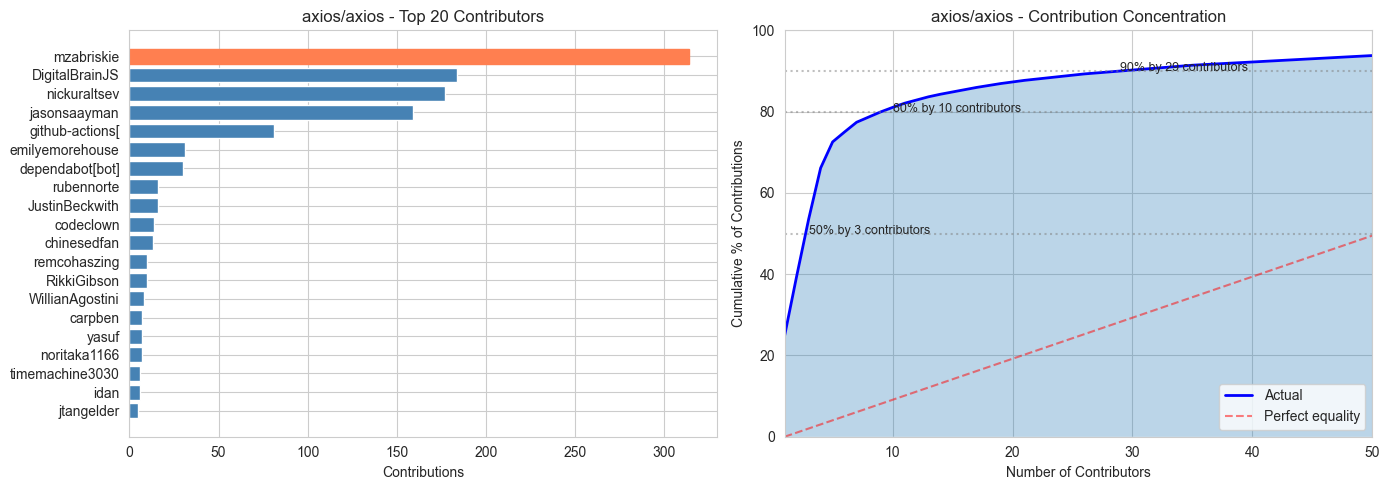

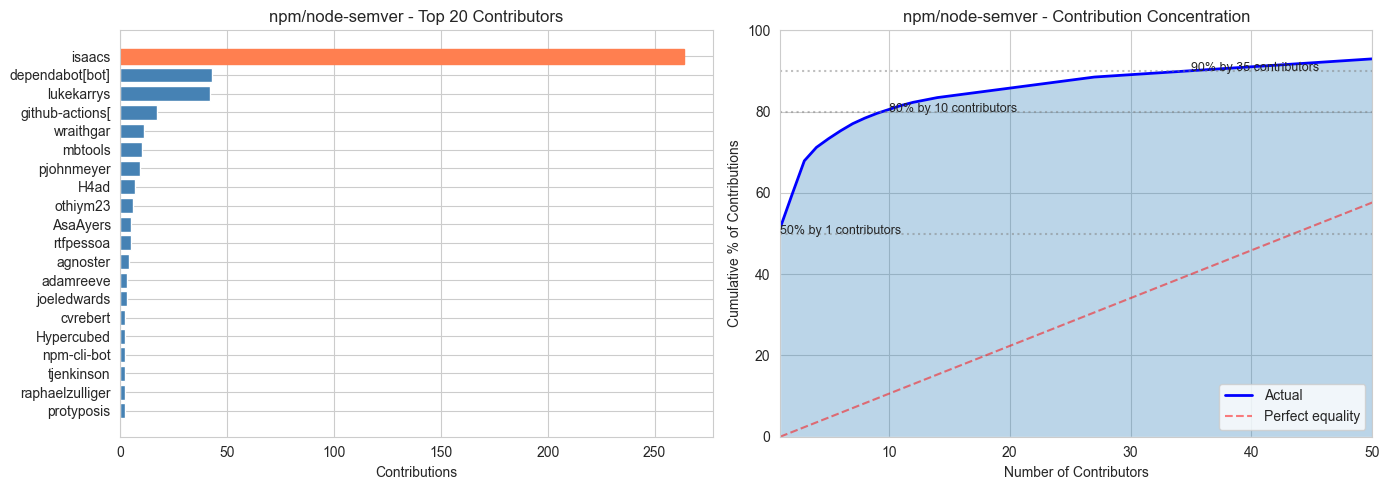

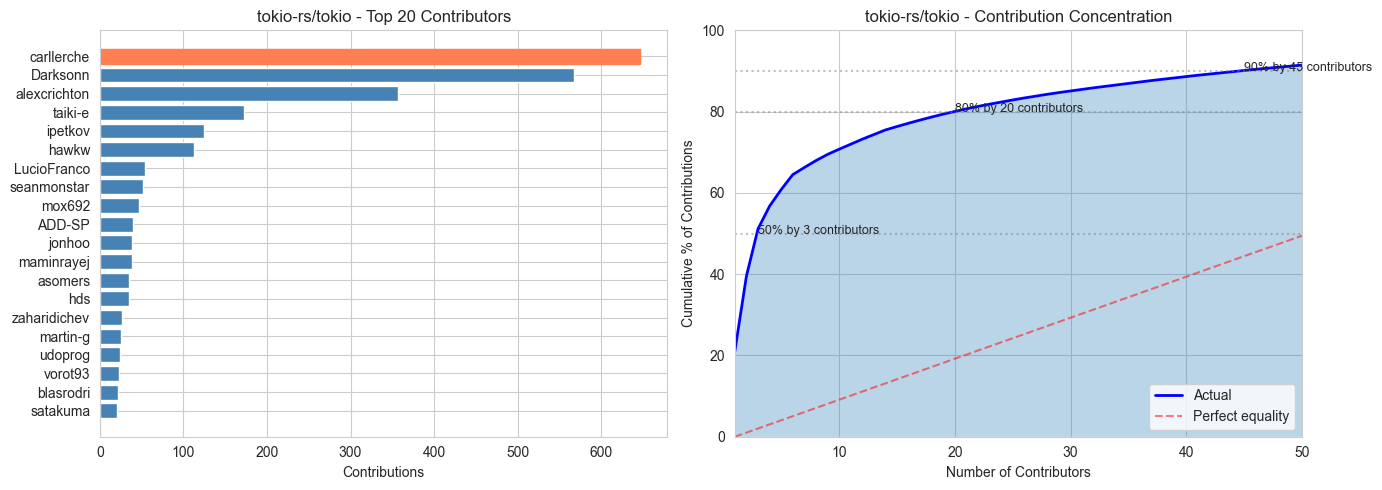

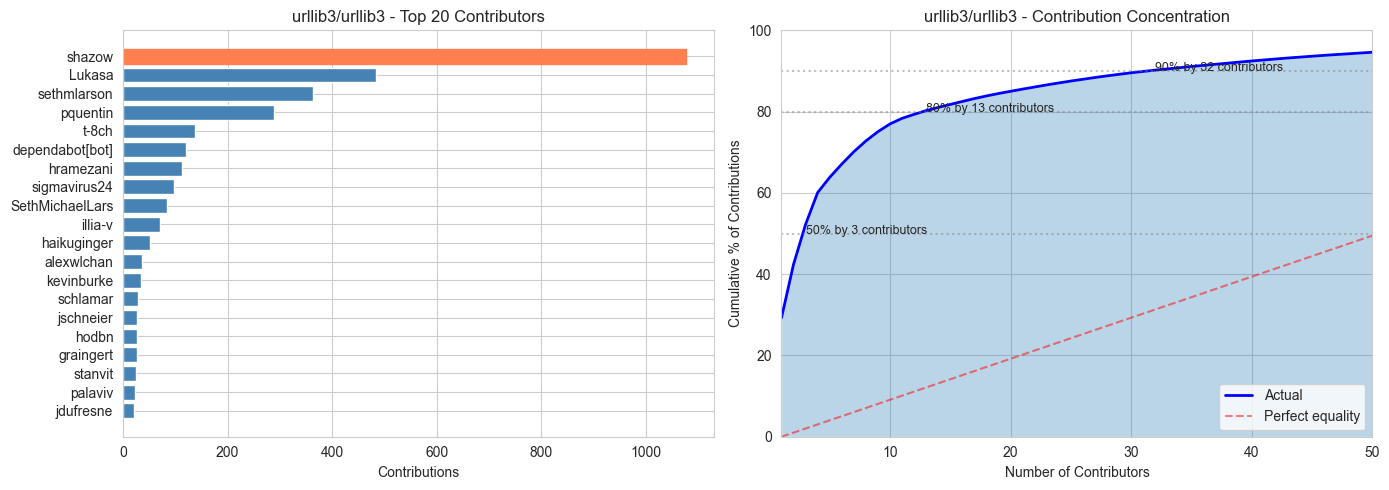

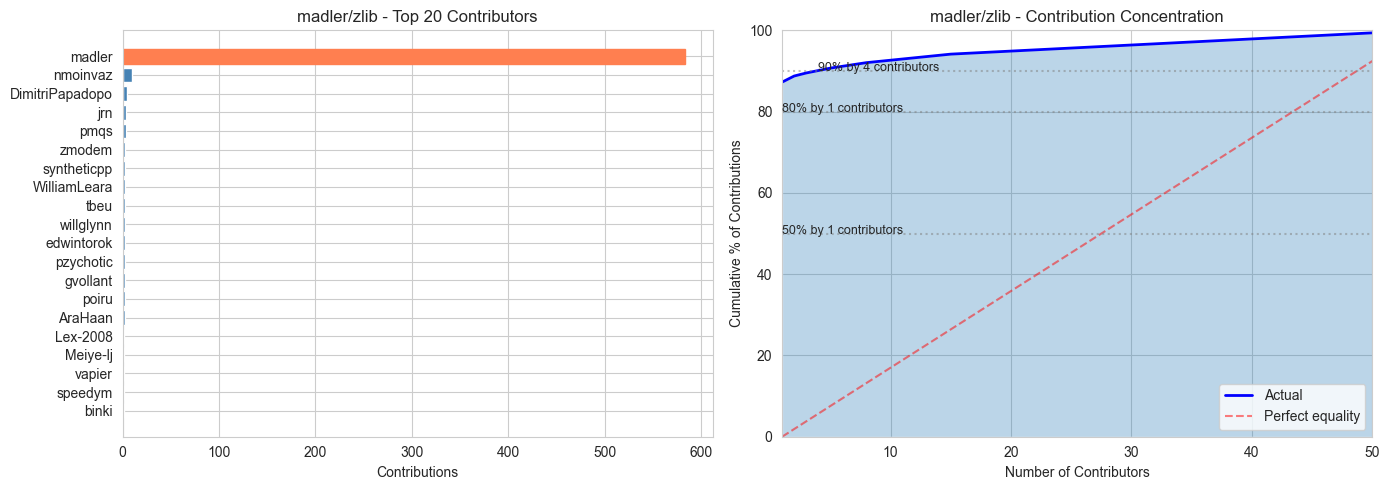

In [15]:
# Plot contribution distribution for each project
for repo_name, data in projects.items():
    contributors = data['contributors'][:20]  # Top 20
    
    if len(contributors) == 0:
        continue
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar chart of top contributors
    names = [c['login'][:15] for c in contributors]
    contributions = [c['contributions'] for c in contributors]
    
    ax1 = axes[0]
    bars = ax1.barh(names[::-1], contributions[::-1], color='steelblue')
    ax1.set_xlabel('Contributions')
    ax1.set_title(f'{repo_name} - Top 20 Contributors')
    
    # Highlight top contributor
    bars[-1].set_color('coral')
    
    # Cumulative contribution curve (Lorenz-like)
    all_contributors = data['contributors']
    all_contributions = sorted([c['contributions'] for c in all_contributors], reverse=True)
    cumulative = np.cumsum(all_contributions) / sum(all_contributions) * 100
    
    ax2 = axes[1]
    ax2.plot(range(1, len(cumulative) + 1), cumulative, 'b-', linewidth=2, label='Actual')
    ax2.plot([1, len(cumulative)], [0, 100], 'r--', alpha=0.5, label='Perfect equality')
    ax2.fill_between(range(1, len(cumulative) + 1), cumulative, alpha=0.3)
    ax2.set_xlabel('Number of Contributors')
    ax2.set_ylabel('Cumulative % of Contributions')
    ax2.set_title(f'{repo_name} - Contribution Concentration')
    ax2.legend()
    ax2.set_xlim(1, min(50, len(cumulative)))
    ax2.set_ylim(0, 100)
    
    # Add annotation for key percentages
    for threshold in [50, 80, 90]:
        idx = np.searchsorted(cumulative, threshold)
        if idx < len(cumulative):
            ax2.axhline(y=threshold, color='gray', linestyle=':', alpha=0.5)
            ax2.annotate(f'{threshold}% by {idx+1} contributors', 
                        xy=(idx+1, threshold), fontsize=9)
    
    plt.tight_layout()
    plt.show()

## 5. Stadium Classification Analysis

Based on our research framework, a **Stadium project** exhibits:
- Low normalized entropy (< 0.5)
- High top contributor dominance (> 40%)
- Few active maintainers (≤ 3, or high concentration despite more)

In [16]:
def classify_project(row):
    """Classify project based on entropy and dominance metrics."""
    
    # Stadium indicators
    low_entropy = row['normalized_entropy'] < 0.5
    high_dominance = row['top_contributor_pct'] > 40
    high_top2_dominance = row['top_2_pct'] > 60
    high_gini = row['gini_coefficient'] > 0.7
    
    # Count Stadium indicators
    stadium_score = sum([low_entropy, high_dominance, high_top2_dominance, high_gini])
    
    if stadium_score >= 3:
        return 'Stadium (Strong)'
    elif stadium_score >= 2:
        return 'Stadium (Likely)'
    elif stadium_score >= 1:
        return 'Hybrid/Uncertain'
    else:
        return 'Federation/Club'

if len(df_entropy) > 0:
    df_entropy['classification'] = df_entropy.apply(classify_project, axis=1)
    
    print("\n" + "=" * 60)
    print("PROJECT CLASSIFICATION RESULTS")
    print("=" * 60)
    
    for _, row in df_entropy.iterrows():
        print(f"\n{row['repository']}:")
        print(f"  Classification: {row['classification']}")
        print(f"  Normalized Entropy: {row['normalized_entropy']:.3f}")
        print(f"  Top Contributor: {row['top_contributor']} ({row['top_contributor_pct']:.1f}%)")
        print(f"  Top 2 Contributors: {row['top_2_pct']:.1f}%")
        print(f"  Gini Coefficient: {row['gini_coefficient']:.3f}")
    
    print("\n" + "=" * 60)


PROJECT CLASSIFICATION RESULTS

babel/babel:
  Classification: Hybrid/Uncertain
  Normalized Entropy: 0.584
  Top Contributor: sebmck (36.0%)
  Top 2 Contributors: 44.9%
  Gini Coefficient: 0.851

benjaminp/six:
  Classification: Stadium (Strong)
  Normalized Entropy: 0.361
  Top Contributor: benjaminp (73.3%)
  Top 2 Contributors: 78.0%
  Gini Coefficient: 0.856

pnggroup/libpng:
  Classification: Stadium (Strong)
  Normalized Entropy: 0.360
  Top Contributor: jbowler (46.2%)
  Top 2 Contributors: 85.2%
  Gini Coefficient: 0.888

curl/curl:
  Classification: Stadium (Strong)
  Normalized Entropy: 0.421
  Top Contributor: bagder (57.3%)
  Top 2 Contributors: 64.8%
  Gini Coefficient: 0.914

psf/requests:
  Classification: Hybrid/Uncertain
  Normalized Entropy: 0.586
  Top Contributor: kennethreitz (31.6%)
  Top 2 Contributors: 50.8%
  Gini Coefficient: 0.790

rust-random/rand:
  Classification: Hybrid/Uncertain
  Normalized Entropy: 0.564
  Top Contributor: dhardy (37.7%)
  Top 2 Cont

## 6. Governance Patterns Analysis

In [17]:
# Analyze governance files presence
governance_data = []

for repo_name, data in projects.items():
    gov_files = data.get('governance_files', {})
    governance_data.append({
        'repository': repo_name,
        'GOVERNANCE.md': gov_files.get('GOVERNANCE.md', False),
        'CONTRIBUTING.md': gov_files.get('CONTRIBUTING.md', False),
        'CODE_OF_CONDUCT.md': gov_files.get('CODE_OF_CONDUCT.md', False),
        'SECURITY.md': gov_files.get('SECURITY.md', False),
        'MAINTAINERS.md': gov_files.get('MAINTAINERS.md', False),
        'CODEOWNERS': gov_files.get('.github/CODEOWNERS', False),
    })

df_governance = pd.DataFrame(governance_data)

print("Governance Files Present:")
print("─" * 60)
for _, row in df_governance.iterrows():
    print(f"\n{row['repository']}:")
    for col in df_governance.columns[1:]:
        status = "✓" if row[col] else "✗"
        print(f"  {status} {col}")

Governance Files Present:
────────────────────────────────────────────────────────────

babel/babel:
  ✗ GOVERNANCE.md
  ✓ CONTRIBUTING.md
  ✓ CODE_OF_CONDUCT.md
  ✓ SECURITY.md
  ✗ MAINTAINERS.md
  ✗ CODEOWNERS

benjaminp/six:
  ✗ GOVERNANCE.md
  ✗ CONTRIBUTING.md
  ✗ CODE_OF_CONDUCT.md
  ✗ SECURITY.md
  ✗ MAINTAINERS.md
  ✗ CODEOWNERS

pnggroup/libpng:
  ✗ GOVERNANCE.md
  ✗ CONTRIBUTING.md
  ✗ CODE_OF_CONDUCT.md
  ✗ SECURITY.md
  ✗ MAINTAINERS.md
  ✗ CODEOWNERS

curl/curl:
  ✗ GOVERNANCE.md
  ✗ CONTRIBUTING.md
  ✗ CODE_OF_CONDUCT.md
  ✓ SECURITY.md
  ✗ MAINTAINERS.md
  ✓ CODEOWNERS

psf/requests:
  ✗ GOVERNANCE.md
  ✗ CONTRIBUTING.md
  ✗ CODE_OF_CONDUCT.md
  ✗ SECURITY.md
  ✗ MAINTAINERS.md
  ✗ CODEOWNERS

rust-random/rand:
  ✗ GOVERNANCE.md
  ✗ CONTRIBUTING.md
  ✗ CODE_OF_CONDUCT.md
  ✓ SECURITY.md
  ✗ MAINTAINERS.md
  ✗ CODEOWNERS

yaml/pyyaml:
  ✗ GOVERNANCE.md
  ✗ CONTRIBUTING.md
  ✗ CODE_OF_CONDUCT.md
  ✗ SECURITY.md
  ✗ MAINTAINERS.md
  ✗ CODEOWNERS

pypa/pip:
  ✗ GOVERNANCE.md

## 7. Export Analysis Results

In [18]:
# Merge all analysis into single DataFrame
if len(df_entropy) > 0 and len(df_summary) > 0:
    df_analysis = df_summary.merge(df_entropy, on='repository')
    
    # Save to CSV
    output_path = Path("../data/processed/analysis_results.csv")
    output_path.parent.mkdir(parents=True, exist_ok=True)
    df_analysis.to_csv(output_path, index=False)
    
    print(f"✅ Analysis saved to: {output_path}")
    
    # Display final table
    display_cols = ['repository', 'stars', 'contributors', 'active_maintainers', 
                    'normalized_entropy', 'top_contributor_pct', 'gini_coefficient', 
                    'classification']
    df_analysis[display_cols]

✅ Analysis saved to: ../data/processed/analysis_results.csv


## Next Steps

1. **Collect more Stadium candidates** from `data/stadium_candidates.md`
2. **Compare with Federation/Club projects** for statistical validation
3. **Run hypothesis tests** (H1-H6) once sample sizes are sufficient
4. **Temporal entropy analysis** - how entropy changes over time